In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from rich.progress import track
from rich import progress
import IPython

from centrex_trajectories import (
    Coordinates,
    Gravity,
    PropagationType,
    Velocities,
    propagate_trajectories,
    PropagationOptions,
)
from centrex_trajectories.particles import TlF
from centrex_trajectories.beamline_objects import (
    CircularAperture,
    ElectrostaticQuadrupoleLens,
    RectangularAperture,
    Section,
    Bore,
)
from centrex_trajectories.visualization import plot_beamline

In [2]:
plt.rcParams.update({"font.size": 14})

In [3]:
class TaskSpeed(progress.ProgressColumn):
    def render(self, task):
        if task.speed is None:
            return ""
        elif task.speed >= 0.1:
            return f"{( task.speed or 0 ):.1f}/s"
        else:
            return f"{( 1 / task.speed or 0):.1f} s/i"

In [4]:
n_trajectories = 3_000_000
options = PropagationOptions(verbose=False, n_cores=8)
gravity = Gravity(0, -9.81, 0)
particle = TlF()

# EQL parameters
L = 0.6
R = 1.75 * 25.4e-3 / 2
V = 28_000


# DET parameters current aperture
wx = 13e-3
wy = 3e-3

# conversion factors
in_to_m = 25.4e-3

n_nipples = 2

# beamline lengths
distance_lens_bbexit = 36 * in_to_m
lens_chamber_length = (24 + 5 / 8) * in_to_m
lens_reducer_flange = (7 / 8 + 3 + 1 / 8) * in_to_m
lens_electrode_length = 0.6  # m
nipple_length = 39 * in_to_m
distance_det_center = 5.25 * in_to_m
lens_reducer_flange = (3 + 1 / 8 + 7 / 8) * in_to_m
bs_flange = 3 / 4 * in_to_m
rc_chamber_length_no_flanges = 10.5 * in_to_m
rc_chamber_center_from_bs_front = (16 + 3 / 8) * in_to_m
rc_aperture_from_center = 3.56 * in_to_m
rc_aperture_width = 8e-3
rc_aperture_height = 6e-3

## Beamline Sections

| What | Length |
| --- | --- |  
| bs flange | 3/4" |
| center of the RC chamber to the beamsource front | 16-3/8" |
| center of the SPA chamber to the beamsource front | 28-3/8" |
| front of the EQL chamber to the beamsource front | 36" |
| lens chamber length | 24-5/8" |
| lens electrode length | 0.6 m |
| lens flange with o-ring | 7/8" |
| lens reducer | 3-1/8" |
| center of DET to start chamber | 5-1/4" |
| long nipple length | 39" |
| rc chamber length without flanges | 10.5" |
| rc chamber front without flanges to front bs flange | 10-3/8" |
| rc aperture from center rc | 3.56" | 
| rc aperture width | 8 mm |
| rc aperture height | 6 mm | 

In [5]:
fourK = Section(
    name="4K shield",
    objects=[CircularAperture(0, 0, 1.75 * in_to_m, in_to_m / 2)],
    start=0,
    stop=(1.75 + 0.25) * 0.0254,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
fourtyK = Section(
    name="40K shield",
    objects=[CircularAperture(0, 0, fourK.stop + 1.25 * in_to_m, in_to_m / 2)],
    start=fourK.stop,
    stop=fourK.stop + (1.25 + 0.25) * 0.0254,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
bbexit = Section(
    name="Beamsource Exit",
    objects=[CircularAperture(0, 0, fourtyK.stop + 2.5 * in_to_m, 2 * in_to_m)],
    start=fourtyK.stop,
    stop=fourtyK.stop + (2.5 + 0.75) * in_to_m,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

rc = Section(
    name="Rotational cooling",
    objects=[
        # RectangularAperture(
        #     x=0,
        #     y=0,
        #     z=bbexit.stop + rc_chamber_center_from_bs_front + rc_aperture_from_center,
        #     wx=rc_aperture_width,
        #     wy=rc_aperture_height,
        # )
        CircularAperture(
            x=0,
            y=0,
            z=bbexit.stop + rc_chamber_center_from_bs_front + rc_aperture_from_center,
            r=0.011,
        )
    ],
    start=bbexit.stop
    + bs_flange
    + rc_chamber_center_from_bs_front
    - rc_chamber_length_no_flanges / 2,
    stop=bbexit.stop
    + rc_chamber_center_from_bs_front
    + rc_chamber_length_no_flanges / 2,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

spa = Section(
    name="State Prep A",
    objects=[
        # CircularAperture(0, 0, bbexit.stop + 19.6 * in_to_m, R * 1.2),
        # CircularAperture(
        #     0,
        #     0,
        #     bbexit.stop + (19.6 + 0.375 + 9.625) * in_to_m,
        #     R * 1.2,
        # ),
    ],
    start=bbexit.stop,
    stop=bbexit.stop + (19.6 + 0.375 + 9.625 + 0.375) * in_to_m,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
eql = ElectrostaticQuadrupoleLens(
    name="Electrostatic Lens",
    objects=[
        Bore(
            x=0,
            y=0,
            z=bbexit.stop
            + distance_lens_bbexit
            + (lens_chamber_length - lens_electrode_length) / 2,
            length=lens_electrode_length,
            radius=R,
        )
    ],
    start=bbexit.stop
    + distance_lens_bbexit
    + (lens_chamber_length - lens_electrode_length) / 2,
    stop=bbexit.stop
    + distance_lens_bbexit
    + lens_chamber_length
    - (lens_chamber_length - lens_electrode_length) / 2,
    V=V,
    R=R,
    save_collisions=False,
)
det = Section(
    name="Detection",
    objects=[
        RectangularAperture(
            0,
            0,
            eql.stop
            + lens_reducer_flange
            + n_nipples * nipple_length
            + distance_det_center
            + 0.001,
            wx,
            wy,
        )
    ],
    start=eql.stop
    + lens_reducer_flange
    + n_nipples * nipple_length
    + distance_det_center,
    stop=eql.stop
    + lens_reducer_flange
    + n_nipples * nipple_length
    + distance_det_center
    + 1e-2,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
    force=None,
)

In [6]:
origin = Coordinates(
    x=np.random.randn(n_trajectories) * 1.5e-3,
    y=np.random.randn(n_trajectories) * 1.5e-3,
    z=np.zeros(n_trajectories),
)
velocities = Velocities(
    vx=np.random.randn(n_trajectories) * 39.4,
    vy=np.random.randn(n_trajectories) * 39.4,
    vz=np.random.randn(n_trajectories) * 16 + 184,
)

sections = [fourK, fourtyK, bbexit, rc, spa, eql, det]
section_data, trajectories = propagate_trajectories(
    sections,
    origin,
    velocities,
    particle,
    force=gravity,
    options=options,
)

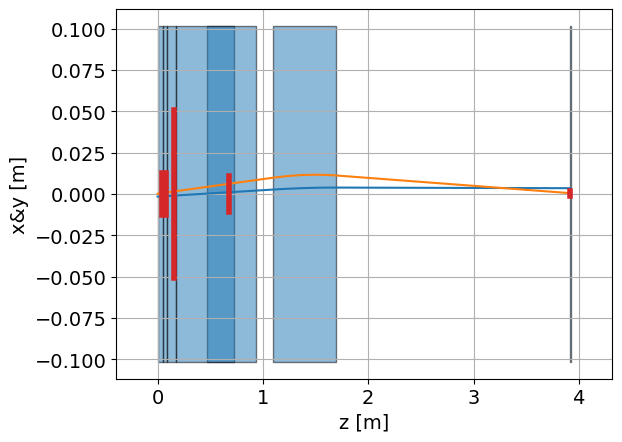

In [7]:
traj = trajectories[list(trajectories.keys())[0]]

fig, ax = plt.subplots()
ax.plot(traj.z, traj.x)
ax.plot(traj.z, traj.y)

plot_beamline(sections, ax=ax)

ax.set_xlabel("z [m]")
ax.set_ylabel("x&y [m]")

ax.grid(True)

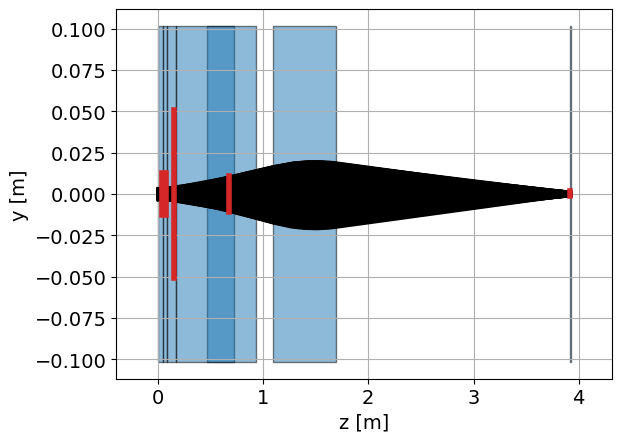

In [8]:
fig, ax = plt.subplots()
for traj in trajectories.values():
    ax.plot(traj.z, traj.y, color="k")

plot_beamline(sections, ax=ax)

ax.set_xlabel("z [m]")
ax.set_ylabel("y [m]")

ax.grid(True)

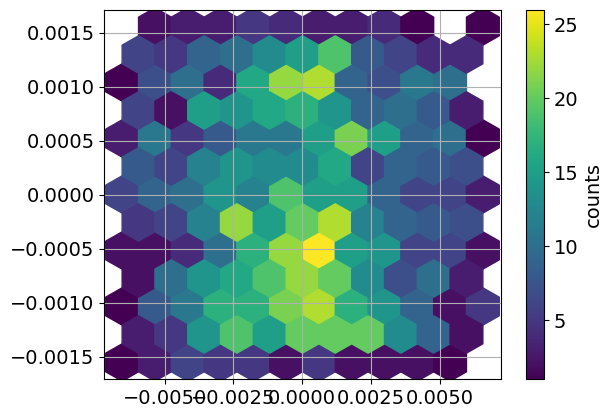

In [9]:
x, y = np.array([(traj.x[-1], traj.y[-1]) for traj in trajectories.values()]).T

fig, ax = plt.subplots()

hb = ax.hexbin(x, y, gridsize=11, mincnt=1, marginals=False)

cbar = fig.colorbar(hb, ax=ax, label="counts")

ax.grid(True)

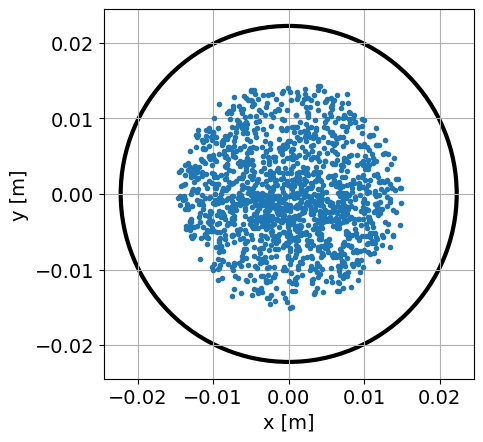

In [10]:
xs = [traj.x[5] for traj in trajectories.values()]
ys = [traj.y[5] for traj in trajectories.values()]

fig, ax = plt.subplots()
ax.add_patch(plt.Circle((0, 0), 1.75 / 2 * in_to_m, fill=False, lw=3))
ax.plot(xs, ys, ".")

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_aspect(1)
ax.grid(True)

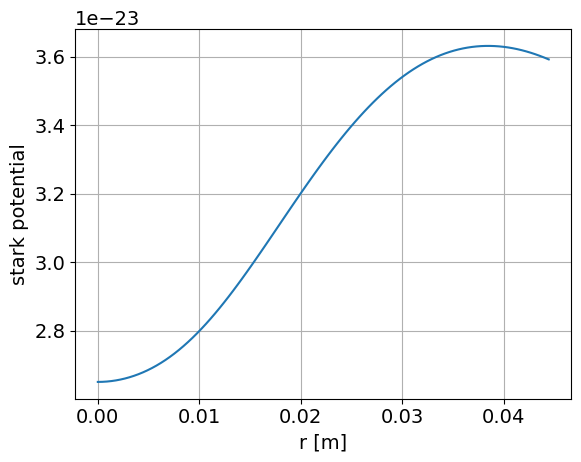

In [44]:
r = np.linspace(0, 2*R, 101)
fig, ax = plt.subplots()
ax.plot(r, eql.stark_potential(r, 0, 0))

ax.set_xlabel("r [m]")
ax.set_ylabel("stark potential")

ax.grid(True)

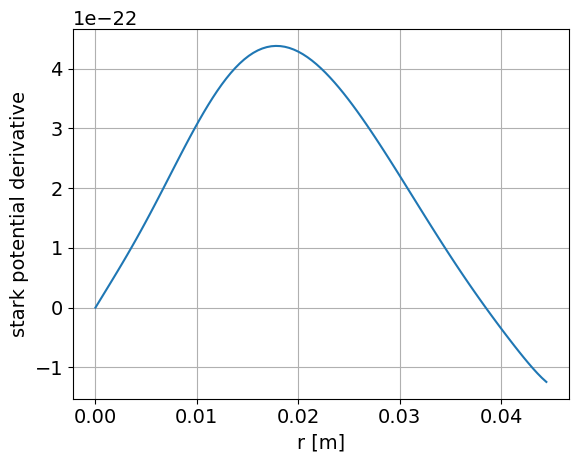

In [43]:
r = np.linspace(0, 2*R, 101)
fig, ax = plt.subplots()
ax.plot(r, eql._poly_stark_derivative_radial(r))

ax.set_xlabel("r [m]")
ax.set_ylabel("stark potential derivative")

ax.grid(True)

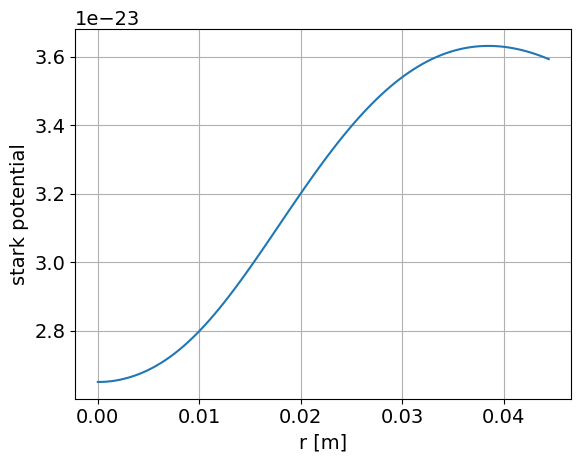

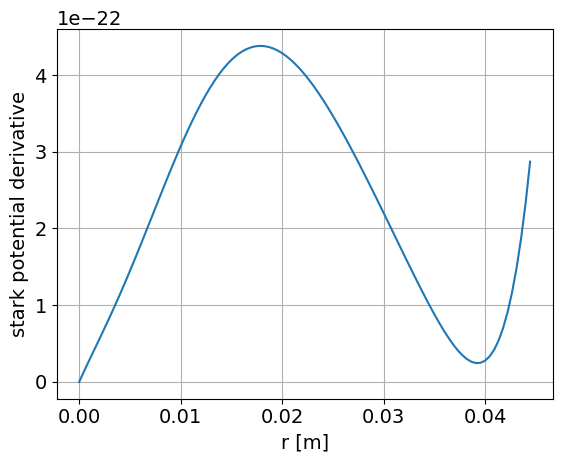

In [46]:
def test():

    from typing import List, Union, Any, Tuple
    import numpy.typing as npt
    from centrex_trajectories.beamline_objects import ODESection
    class ElectrostaticQuadrupoleLens(ODESection):
        """
        Electrostatic Quadrupole Lens class
        """

        def __init__(
            self,
            name: str,
            objects: List[Any],
            start: float,
            stop: float,
            V: float,
            R: float,
            save_collisions: bool = False,
        ) -> None:
            """
            Electrostatic Quadrupole Lens Section

            Args:
                name (str): name of electrostatic quadrupole lens
                objects (List): objects inside the section which particles can collide with
                start (float): start of section in z [m]
                stop (float): stop of section in z [m]
                V (float): Voltage on electrodes [Volts]
                R (float): radius of lens bore [m]
                save_collisions (Optional[bool], optional): Save the coordinates and
                                                        velocities of collisions in this
                                                        section. Defaults to False.
            """
            super().__init__(name, objects, start, stop, save_collisions)
            self.V = V
            self.R = R
            self._check_objects()
            self._initialize_potentials()

        def _initialize_potentials(self):
            """
            Generate the radial derivative of the Stark potential for the force calculation
            """
            # fit a polynomial to the stark potential as a fucntion of r
            r = np.linspace(0, 1.5 * self.R, 201)
            offset = self.stark_potential(0, 0, 0)
            self._poly_stark_radial = np.polyfit(
                r, self.stark_potential(r, 0, 0) - offset, 11
            )
            # take the derivative
            self._poly_stark_derivative_radial = np.polyder(
                np.poly1d(self._poly_stark_radial)
            )
            # force intercept to go through zero for the force by fitting a polynomial
            # that intercepts zero through the derivative as a function of r
            R_ = np.vstack((r**11, r**10, r**9, r**8, r**7, r**6, r**5, r**4, r**3, r**2, r)).T
            y = self._poly_stark_derivative_radial(r)
            p = np.linalg.lstsq(R_, y, rcond=None)[0]
            p = np.append(p, [0])
            # creating the function to evaluate the derivative of the stark potential in r
            self._poly_stark_derivative_radial = np.poly1d(p)

        def electric_field(
            self,
            x: Union[npt.NDArray[np.float64], float],
            y: Union[npt.NDArray[np.float64], float],
            z: Union[npt.NDArray[np.float64], float],
        ) -> Union[npt.NDArray[np.float64], float]:
            """
            Calculate the electric field of the lens at x,y,z

            Args:
                x (Union[NDArray[np.float64], float]): x coordinate(s) [m]
                y (Union[NDArray[np.float64], float]): y coordinate(s) [m]
                z (Union[NDArray[np.float64], float]): z coordinate(s) [m]

            Returns:
                Union[NDArray[np.float64], float]: electric field at x,y,z in V/m
            """
            return 2 * self.V * np.sqrt(x**2 + y**2) / (self.R) ** 2

        def force(
            self,
            t: float,
            x: Union[npt.NDArray[np.float64], float],
            y: Union[npt.NDArray[np.float64], float],
            z: Union[npt.NDArray[np.float64], float],
        ) -> Union[
            Tuple[
                npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64]
            ],
            Tuple[float, float, float],
        ]:
            """
            Calculate the force at x,y,z

            Args:
                t (float): time [s]
                x (Union[NDArray[np.float64], float]): x coordinate(s) [m]
                y (Union[NDArray[np.float64], float]): y coordinate(s) [m]
                z (Union[NDArray[np.float64], float]): z coordinate(s) [m]

            Returns:
                List: force in x, y and z
            """
            r = np.sqrt(x**2 + y**2)
            dx = x / r
            dy = y / r
            stark = -self._poly_stark_derivative_radial(r)
            return (stark * dx, stark * dy, 0)

        def stark_potential_derivative(
            self,
            x: Union[npt.NDArray[np.float64], float],
            y: Union[npt.NDArray[np.float64], float],
            z: Union[npt.NDArray[np.float64], float],
        ) -> Union[npt.NDArray[np.float64], float]:
            """
            Calculate the radial derivative of the stark potential at x,y,z

            Args:
                x (Union[NDArray[np.float64], float]): x coordinate(s) [m]
                y (Union[NDArray[np.float64], float]): y coordinate(s) [m]
                z (Union[NDArray[np.float64], float]): z coordinate(s) [m]

            Returns:
                Union[np.ndarray, float]: radial derivative of stark potential
            """
            return self._poly_stark_derivative_radial(np.sqrt(x**2 + y**2))

        def stark_potential(
            self,
            x: Union[npt.NDArray[np.float64], float],
            y: Union[npt.NDArray[np.float64], float],
            z: Union[npt.NDArray[np.float64], float],
        ) -> Union[npt.NDArray[np.float64], float]:
            """
            Calculate the the stark potential at x,y,z

            Args:
                x (Union[NDArray[np.float64], float]): x coordinate(s) [m]
                y (Union[NDArray[np.float64], float]): y coordinate(s) [m]
                z (Union[NDArray[np.float64], float]): z coordinate(s) [m]

            Returns:
                Union[NDArray[np.float64], float]: stark potential
            """
            E = self.electric_field(x, y, z)
            return stark_potential(E)

        def stark_potential_E(
            self, E: Union[npt.NDArray[np.float64], float]
        ) -> Union[npt.NDArray[np.float64], float]:
            """
            Calculate the stark potential as a function of electric field in V/m

            Args:
                E (Union[np.ndarray, float]): electric field in V/m

            Returns:
                Union[np.ndarray, float]: stark potential
            """
            return stark_potential(E)

    stark_poly = np.array([-2.64635736e-97,  2.28550557e-89, -6.12626119e-82,  8.26619166e-75,
        -6.51917201e-68,  3.13538715e-61, -8.91440907e-55,  1.31681694e-48,
        -8.89845016e-43,  1.40144717e-36, -5.02092082e-32,  2.65086867e-23])

    stark_potential = np.poly1d(stark_poly)
    stark_potential_derivative = np.polyder(stark_potential)

    eql = ElectrostaticQuadrupoleLens(
        name="Electrostatic Lens",
        objects=[
            Bore(
                x=0,
                y=0,
                z=bbexit.stop
                + distance_lens_bbexit
                + (lens_chamber_length - lens_electrode_length) / 2,
                length=lens_electrode_length,
                radius=R,
            )
        ],
        start=bbexit.stop
        + distance_lens_bbexit
        + (lens_chamber_length - lens_electrode_length) / 2,
        stop=bbexit.stop
        + distance_lens_bbexit
        + lens_chamber_length
        - (lens_chamber_length - lens_electrode_length) / 2,
        V=V,
        R=R,
        save_collisions=False,
    )

    r = np.linspace(0, 2*R, 101)
    fig, ax = plt.subplots()
    ax.plot(r, eql.stark_potential(r, 0, 0))

    ax.set_xlabel("r [m]")
    ax.set_ylabel("stark potential")

    ax.grid(True)

    fig, ax = plt.subplots()
    ax.plot(r, eql._poly_stark_derivative_radial(r))

    ax.set_xlabel("r [m]")
    ax.set_ylabel("stark potential derivative")

    ax.grid(True)

test()

## Scan Lens Voltage

In [11]:
def lens_scan_function(
    origin: Coordinates,
    velocities: Velocities,
    voltage: float,
    detection_distance: float,
    length: float = 0.6,
    radius: float = 0.022225,
):
    eql = ElectrostaticQuadrupoleLens(
        name="Electrostatic Lens",
        objects=[
            Bore(
                x=0,
                y=0,
                z=bbexit.stop
                + distance_lens_bbexit
                + (lens_chamber_length - lens_electrode_length) / 2,
                length=lens_electrode_length,
                radius=radius,
            )
        ],
        start=bbexit.stop
        + distance_lens_bbexit
        + (lens_chamber_length - lens_electrode_length) / 2,
        stop=bbexit.stop
        + distance_lens_bbexit
        + (lens_chamber_length - lens_electrode_length) / 2
        + length,
        V=voltage,
        R=radius,
        save_collisions=False,
    )
    det = Section(
        name="Detection",
        objects=[
            RectangularAperture(
                0,
                0,
                eql.stop + detection_distance + 0.001,
                wx,
                wy,
            )
        ],
        start=eql.stop + detection_distance,
        stop=eql.stop + detection_distance + 1e-2,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
        force=None,
    )

    sections = [fourK, fourtyK, bbexit, rc, spa, eql, det]
    section_data, trajectories = propagate_trajectories(
        sections,
        origin,
        velocities,
        particle,
        force=gravity,
        options=options,
    )
    return section_data, trajectories, sections

In [12]:
origin = Coordinates(
    x=np.random.randn(n_trajectories) * 1.5e-3,
    y=np.random.randn(n_trajectories) * 1.5e-3,
    z=np.zeros(n_trajectories),
)
velocities = Velocities(
    vx=np.random.randn(n_trajectories) * 39.4,
    vy=np.random.randn(n_trajectories) * 39.4,
    vz=np.random.randn(n_trajectories) * 16 + 184,
)

voltages = np.linspace(0, 30e3, 7)

data = []
for voltage in track(voltages):
    data.append(
        lens_scan_function(
            origin,
            velocities,
            voltage,
            detection_distance=lens_reducer_flange
            + 1 * nipple_length
            + distance_det_center,
        )
    )

Output()

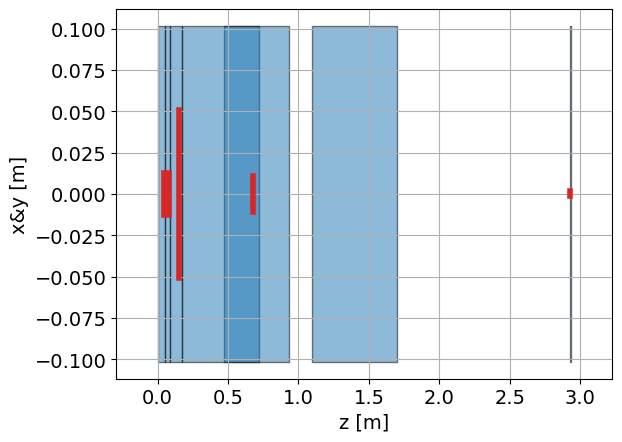

In [13]:
traj = trajectories[list(trajectories.keys())[0]]

fig, ax = plt.subplots()

plot_beamline(data[0][2], ax=ax)

ax.set_xlabel("z [m]")
ax.set_ylabel("x&y [m]")

ax.grid(True)

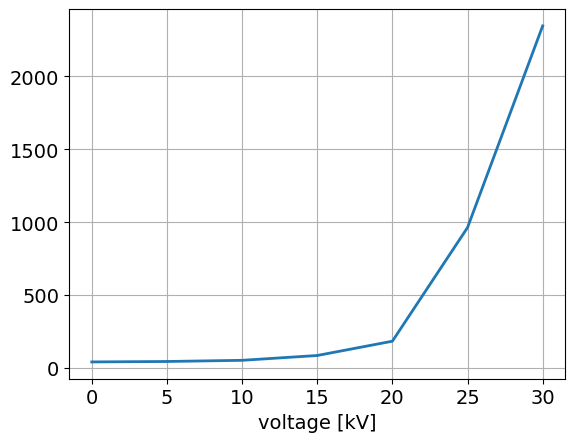

In [14]:
survived = [dat[0][-1].survived for dat in data]
fig, ax = plt.subplots()
ax.plot(voltages / 1e3, survived, lw=2)

ax.set_xlabel("voltage [kV]")
ax.grid(True)

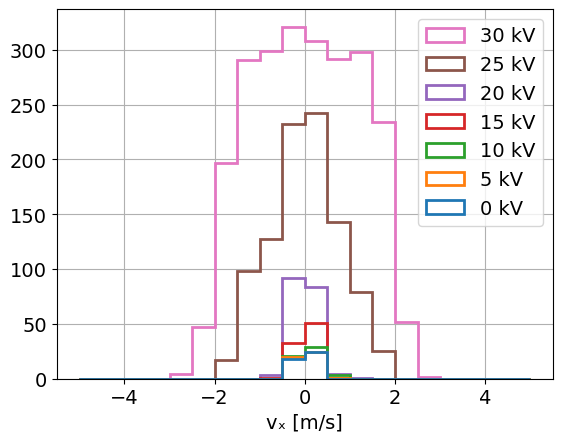

In [15]:
vxs = [[traj.vx[-1] for traj in dat[1].values()] for dat in data]
bins = np.linspace(-5, 5, 21)
labels = [f"{voltage/1e3:.0f} kV" for voltage in voltages]

fig, ax = plt.subplots()
ax.hist(vxs, bins=bins, histtype="step", lw=2, density=False, label=labels)

ax.set_xlabel("vₓ [m/s]")
ax.legend()
ax.grid(True)

## Scan Lens Voltage and Detection Distance

### Without EQL
For referencing gain, taking into account that the gain should be calculated as if the lens is not there, e.g. the beamline is shorter

In [56]:
def no_lens_scan_function(
    origin: Coordinates,
    velocities: Velocities,
    detection_distance: float,
):
    det = Section(
        name="Detection",
        objects=[
            RectangularAperture(
                0,
                0,
                bbexit.stop + distance_lens_bbexit + detection_distance + 0.001,
                wx,
                wy,
            )
        ],
        start=bbexit.stop + distance_lens_bbexit + detection_distance,
        stop=bbexit.stop + distance_lens_bbexit + detection_distance + 1e-2,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
        force=None,
    )

    sections = [fourK, fourtyK, bbexit, rc, spa, det]
    section_data, trajectories = propagate_trajectories(
        sections,
        origin,
        velocities,
        particle,
        force=gravity,
        options=options,
    )
    return section_data, trajectories, sections

In [57]:
origin = Coordinates(
    x=np.random.randn(n_trajectories) * 1.5e-3,
    y=np.random.randn(n_trajectories) * 1.5e-3,
    z=np.zeros(n_trajectories),
)
velocities = Velocities(
    vx=np.random.randn(n_trajectories) * 39.4,
    vy=np.random.randn(n_trajectories) * 39.4,
    vz=np.random.randn(n_trajectories) * 16 + 184,
)

nr_nipples = 4
distances = (
    lens_reducer_flange
    + np.arange(nr_nipples + 1) * nipple_length
    + distance_det_center
)

data_no_lens = []
with progress.Progress(
    progress.SpinnerColumn(),
    progress.TextColumn(
        "{task.description} [progress.percentage]{task.percentage:>3.0f}%",
        justify="right",
    ),
    progress.BarColumn(),
    progress.MofNCompleteColumn(),
    progress.TextColumn("•"),
    TaskSpeed(),
    progress.TextColumn("•"),
    progress.TimeElapsedColumn(),
    progress.TextColumn("•"),
    progress.TimeRemainingColumn(),
) as pb:
    t1 = pb.add_task("distance", total=len(distances))
    for idd, distance in enumerate(distances):
        dat = no_lens_scan_function(origin, velocities, detection_distance=distance)
        pb.update(task_id=t1, completed=idd + 1)
        data_no_lens.append((distance, [dat]))
    pb.refresh()

Output()

### With EQL

In [58]:
nr_nipples = 4
distances = (
    lens_reducer_flange
    + np.arange(nr_nipples + 1) * nipple_length
    + distance_det_center
)
voltages = np.linspace(0, 30e3, 25)

data = []
with progress.Progress(
    progress.SpinnerColumn(),
    progress.TextColumn(
        "{task.description} [progress.percentage]{task.percentage:>3.0f}%",
        justify="right",
    ),
    progress.BarColumn(),
    progress.MofNCompleteColumn(),
    progress.TextColumn("•"),
    TaskSpeed(),
    progress.TextColumn("•"),
    progress.TimeElapsedColumn(),
    progress.TextColumn("•"),
    progress.TimeRemainingColumn(),
) as pb:
    t1 = pb.add_task("distance", total=len(distances))
    t2 = pb.add_task("voltage", total=len(voltages))
    for idd, distance in enumerate(distances):
        dat = []
        for idv, voltage in enumerate(voltages):
            dat.append(
                lens_scan_function(
                    origin, velocities, voltage, detection_distance=distance
                )
            )
            pb.update(task_id=t2, completed=idv + 1)
        if idd < len(distances) - 1:
            pb.reset(t2)
        pb.update(task_id=t1, completed=idd + 1)
        data.append((distance, dat))
    pb.refresh()

Output()

### Total Gain

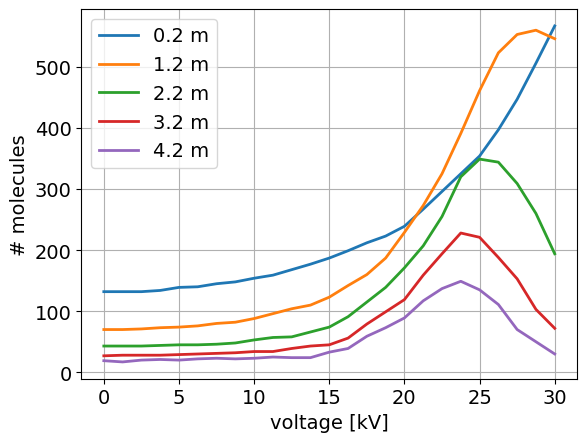

In [59]:
survived = np.array([[d[0][-1].survived for d in dat[1]] for dat in data])
survived_no_lens = np.array(
    [[d[0][-1].survived for d in dat[1]] for dat in data_no_lens]
).flatten()

labels = [f"{dist:.1f} m" for dist in distances]

fig, ax = plt.subplots()
ax.plot(voltages / 1e3, survived.T, lw=2, label=labels[: len(survived)])

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("# molecules")
ax.legend()
ax.grid(True)

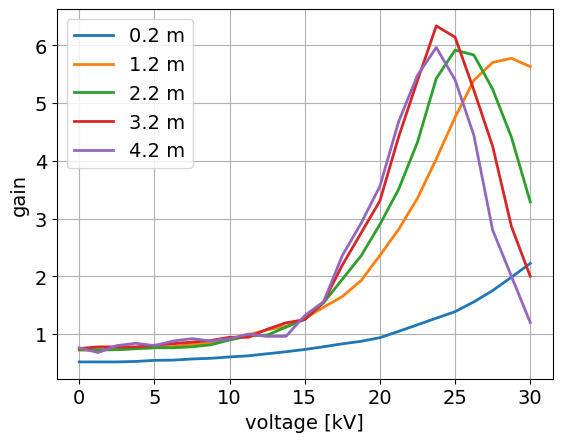

In [60]:
fig, ax = plt.subplots()
ax.plot(
    voltages / 1e3, survived.T / survived_no_lens, lw=2, label=labels[: len(survived)]
)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("gain")
ax.legend()
ax.grid(True)

### Limit Spread for Interaction Region Electrodes

0.02 cm in x because of interaction region electrodes.  
1" in y because of detection chamber and laser limitations. 

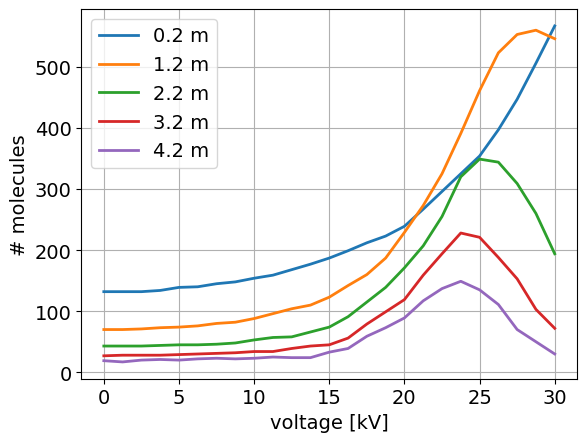

In [61]:
limit_x = 0.02
limit_y = in_to_m

nr_molecules = []
for idd in range(len(distances)):
    xs = [np.array([traj.x[-1] for traj in dat[1].values()]) for dat in data[idd][1]]
    ys = [np.array([traj.y[-1] for traj in dat[1].values()]) for dat in data[idd][1]]
    xs = [np.abs(x) <= limit_x / 2 for x in xs]
    ys = [np.abs(y) <= limit_y / 2 for y in ys]
    total = [(x & y).sum() for x, y in zip(xs, ys)]
    nr_molecules.append(total)

nr_molecules = np.asarray(nr_molecules)

nr_molecules_no_lens = []
for idd in range(len(distances)):
    xs = [
        np.array([traj.x[-1] for traj in dat[1].values()])
        for dat in data_no_lens[idd][1]
    ]
    ys = [
        np.array([traj.y[-1] for traj in dat[1].values()])
        for dat in data_no_lens[idd][1]
    ]
    xs = [np.abs(x) <= limit_x / 2 for x in xs]
    ys = [np.abs(y) <= limit_y / 2 for y in ys]
    total = [(x & y).sum() for x, y in zip(xs, ys)]
    nr_molecules_no_lens.append(total)
nr_molecules_no_lens = np.asarray(nr_molecules_no_lens).flatten()

labels = [f"{dist:.1f} m" for dist in distances]

fig, ax = plt.subplots()
ax.plot(
    voltages / 1e3,
    nr_molecules.T,
    lw=2,
    label=labels[: len(nr_molecules)],
)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("# molecules")
ax.legend()
ax.grid(True)

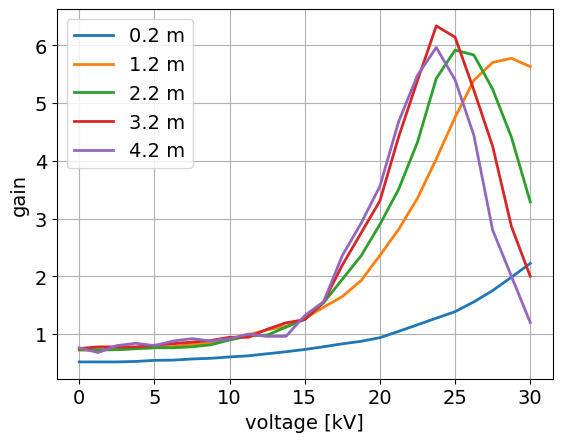

In [62]:
fig, ax = plt.subplots()
ax.plot(
    voltages / 1e3,
    nr_molecules.T / nr_molecules_no_lens,
    lw=2,
    label=labels[: len(nr_molecules)],
)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("gain")
ax.legend()
ax.grid(True)

### Limit Spread current DET chamber

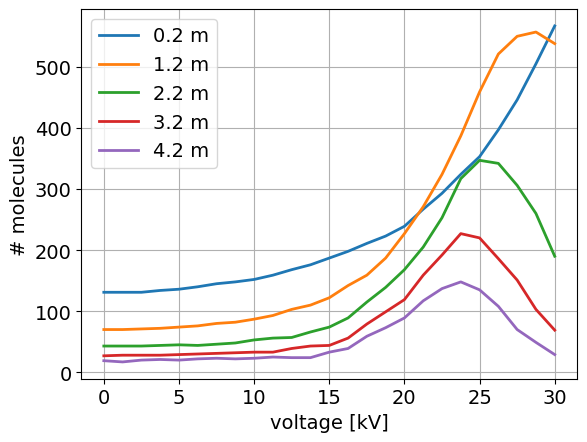

In [63]:
limit_x = 0.013
limit_y = 3e-3

nr_molecules = []
for idd in range(len(distances)):
    xs = [np.array([traj.x[-1] for traj in dat[1].values()]) for dat in data[idd][1]]
    ys = [np.array([traj.y[-1] for traj in dat[1].values()]) for dat in data[idd][1]]
    xs = [np.abs(x) <= limit_x / 2 for x in xs]
    ys = [np.abs(y) <= limit_y / 2 for y in ys]
    total = [(x & y).sum() for x, y in zip(xs, ys)]
    nr_molecules.append(total)

nr_molecules = np.asarray(nr_molecules)

nr_molecules_no_lens = []
for idd in range(len(distances)):
    xs = [
        np.array([traj.x[-1] for traj in dat[1].values()])
        for dat in data_no_lens[idd][1]
    ]
    ys = [
        np.array([traj.y[-1] for traj in dat[1].values()])
        for dat in data_no_lens[idd][1]
    ]
    xs = [np.abs(x) <= limit_x / 2 for x in xs]
    ys = [np.abs(y) <= limit_y / 2 for y in ys]
    total = [(x & y).sum() for x, y in zip(xs, ys)]
    nr_molecules_no_lens.append(total)
nr_molecules_no_lens = np.asarray(nr_molecules_no_lens).flatten()

labels = [f"{dist:.1f} m" for dist in distances]

fig, ax = plt.subplots()
ax.plot(
    voltages / 1e3,
    nr_molecules.T,
    lw=2,
    label=labels[: len(nr_molecules)],
)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("# molecules")
ax.legend()
ax.grid(True)

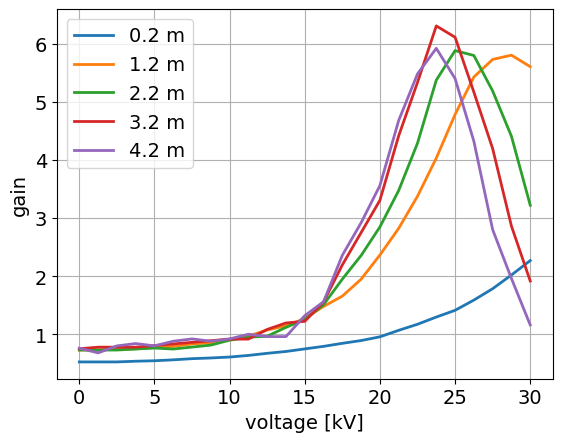

In [64]:
fig, ax = plt.subplots()
ax.plot(
    voltages / 1e3,
    nr_molecules.T / nr_molecules_no_lens,
    lw=2,
    label=labels[: len(nr_molecules)],
)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("gain")
ax.legend()
ax.grid(True)

### Velocities etc

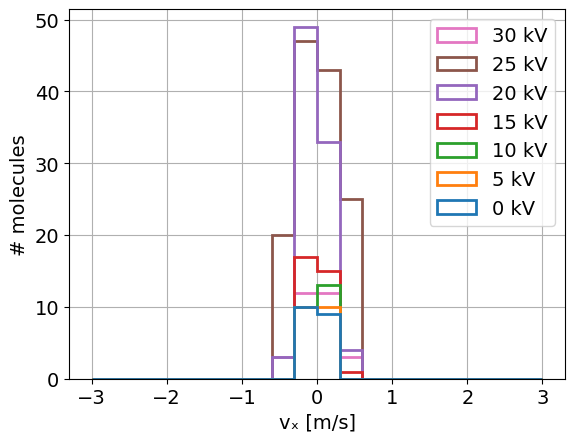

In [65]:
vxs = [[traj.vx[-1] for traj in dat[1].values()] for dat in data[-1][1]][::4]
bins = np.linspace(-3, 3, 21)
labels = [f"{voltage/1e3:.0f} kV" for voltage in voltages][::4]

fig, ax = plt.subplots()
ax.hist(vxs, bins=bins, histtype="step", lw=2, density=False, label=labels)

ax.set_xlabel("vₓ [m/s]")
ax.set_ylabel("# molecules")
ax.legend()
ax.grid(True)

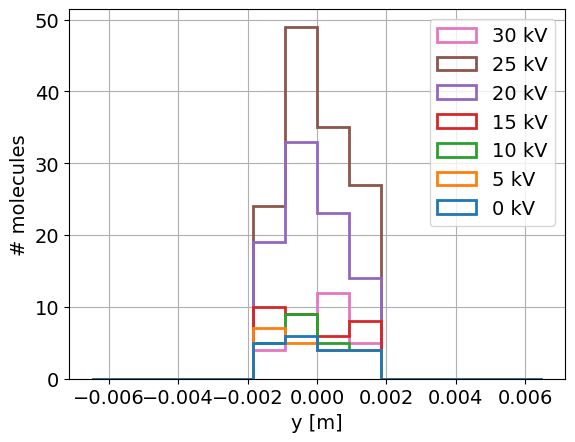

In [66]:
vxs = [[traj.y[-1] for traj in dat[1].values()] for dat in data[-1][1]][::4]
bins = np.linspace(-wx / 2, wx / 2, 15)
labels = [f"{voltage/1e3:.0f} kV" for voltage in voltages][::4]

fig, ax = plt.subplots()
ax.hist(vxs, bins=bins, histtype="step", lw=2, density=False, label=labels)

ax.set_xlabel("y [m]")
ax.set_ylabel("# molecules")
ax.legend()
ax.grid(True)

In [67]:
bins = np.linspace(-4, 4, 21)

max_counts = np.array(
    [
        [
            np.histogram([traj.vx[-1] for traj in d[1].values()], bins=bins)[0]
            for d in dat[1]
        ]
        for dat in data
    ]
).max()

vxs = [[traj.vx[-1] for traj in dat[1].values()] for dat in data[-1][1]][::4]
labels = [f"{voltage/1e3:.0f} kV" for voltage in voltages][::4]

fig, ax = plt.subplots()
ax.hist(vxs, bins=bins, histtype="step", lw=2, density=False, label=labels)
ax.set_ylim(ymax=max_counts * 1.025)

ax.set_xlabel("vₓ [m/s]")
ax.legend()
ax.grid(True)


def animate(
    i,
    ax,
    data,
):
    ax.set_title(f"distance = {distances[i]:.1f} m")
    vxs = [[traj.vx[-1] for traj in dat[1].values()] for dat in data[i][1]][::4]
    for patch in ax.patches:
        patch.remove()
    plt.gca().set_prop_cycle(None)
    ax.hist(vxs, bins=bins, histtype="step", lw=2, density=False, label=labels)
    return ax


ani = animation.FuncAnimation(
    fig,
    animate,
    frames=len(data),
    interval=1_000,
    blit=False,
    fargs=(
        ax,
        data,
    ),
)

vid = ani.to_html5_video()

plt.close()

IPython.display.HTML(vid)

In [68]:
bins = np.linspace(-wx / 2, wx / 2, 15)

max_counts = np.array(
    [
        [
            np.histogram([traj.y[-1] for traj in d[1].values()], bins=bins)[0]
            for d in dat[1]
        ]
        for dat in data
    ]
).max()

ys = [[traj.y[-1] for traj in dat[1].values()] for dat in data[-1][1]][::4]
labels = [f"{voltage/1e3:.0f} kV" for voltage in voltages][::4]

fig, ax = plt.subplots()
ax.hist(ys, bins=bins, histtype="step", lw=2, density=False, label=labels)
ax.set_ylim(ymax=max_counts * 1.025)

ax.set_xlabel("y [m]")
ax.legend()
ax.grid(True)


def animate(
    i,
    ax,
    data,
):
    ax.set_title(f"distance = {distances[i]:.1f} m")
    ys = [[traj.y[-1] for traj in dat[1].values()] for dat in data[i][1]][::4]
    for patch in ax.patches:
        patch.remove()
    ax.set_prop_cycle(None)
    ax.hist(ys, bins=bins, histtype="step", lw=2, density=False, label=labels)
    return ax


ani = animation.FuncAnimation(
    fig,
    animate,
    frames=len(data),
    interval=1_000,
    blit=False,
    fargs=(
        ax,
        data,
    ),
)

vid = ani.to_html5_video()

plt.close()

IPython.display.HTML(vid)

In [69]:
vmin, vmax = 1, 1
for idd in range(len(distances)):
    x, y = np.array([(traj.x[-1], traj.y[-1]) for traj in data[0][1][-1][1].values()]).T
    fig, ax = plt.subplots()
    hb = ax.hexbin(x, y, gridsize=15, mincnt=1, marginals=False)
    if vmax < hb.get_clim()[1]:
        vmax = hb.get_clim()[1]
    plt.close()

fig, ax = plt.subplots()

hb = ax.hexbin(x, y, gridsize=15, mincnt=1, marginals=False, vmin=vmin, vmax=vmax)

cbar = fig.colorbar(hb, ax=ax, label="counts")

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.grid(True)
fig.tight_layout()


def animate(i, ax, data, distance_idx: int = -1):
    x, y = np.array(
        [(traj.x[-1], traj.y[-1]) for traj in data[distance_idx][1][i][1].values()]
    ).T
    ax.collections[0].remove()
    ax.set_title(f"voltage = {voltages[i]/1e3:.0f} kV")
    ax.hexbin(x, y, gridsize=15, mincnt=1, marginals=False, vmin=vmin, vmax=vmax)
    return ax


ani = animation.FuncAnimation(
    fig,
    animate,
    frames=len(voltages),
    interval=1_000,
    blit=False,
    fargs=(
        ax,
        data,
    ),
)

vid = ani.to_html5_video()

plt.close()

IPython.display.HTML(vid)